# Box measurements demo

## Idea
  * Find a ground plane, find a plane for the top of the box
  * Find a minimum rectangle for the top side (and four points)
  * Find the bottom four corners of the box (located on the ground plane).

## What is needed for a bare minimum working demo:
 * Crop only for the ROI *DONE*
 * Detect the ground plane, either using calibration (detect the background without the box) or if
the box is small enough, do the fit using the box. *DONE*

 * Find a rotation matrix to align the ground plane with the coordinate system. *DONE*

 * Find points not on the plane and perform clustering, in good conditions, the biggest cluster should be the box. *DONE*

 * Order the points by the distance to the ground plane *DONE*

 * Take the 0.90% of the point furthest away from the plane *DONE*

 * Make a new plane parallel to the ground plane *NOT NEEDED*

 * Do a projection of the points that are in the +- x% of the new plane on the new plane

 * Find a bounding box around the projected points**

 * Get the 4 coordinates of the bounding box

 * Get the 4 coordinates on the ground plane by projection

 * By here the demo should be able to measure the box dimensions


## What else is needed for the full demo:
 * Figure out an reverse transformation to the RGB image to draw the box on the image
 * Gather more than one point cloud and (average/combine) them.
 * Create a calibration setup

## Helper funtions:
 * A function that creates a point cloud for a plane in a given volume would be handy for visualisation.

In [1]:
# Imports and constants

import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
import copy
import cv2

PATH = './example_pcls/example_5.ply'

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Read the pointcloud
raw_pcl = o3d.io.read_point_cloud(PATH)

### Crop the ROI
----

In [3]:
# Show the pointcloud
o3d.visualization.draw_geometries([raw_pcl])

In [4]:
# Crop only for the ROI

raw_pcl_np = np.asarray(raw_pcl.points)

# Calculate point distances
pcl_dist = np.sqrt(np.sum(np.square(raw_pcl_np), axis=1))

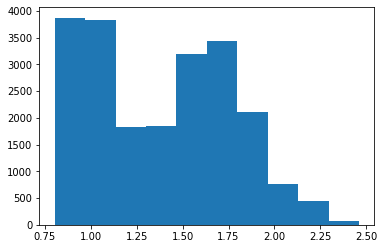

In [5]:
# Plot a histogram of distances
plt.hist(pcl_dist)
plt.show()

In [6]:
# Only take points less than 1 meter away
indices = np.nonzero(pcl_dist < 1.5)[0]
roi_pcl = raw_pcl.select_by_index(indices)
o3d.visualization.draw_geometries([roi_pcl])

### Detect the ground plane
------

In [7]:
# Get the ground plane
plane_eq, plane_inliers = roi_pcl.segment_plane(0.02, 3, 3000)


# Draw the datapoints in the plane
plane_raw = roi_pcl.select_by_index(plane_inliers)
o3d.visualization.draw_geometries([plane_raw])

# Draw the outliers
plane_outliers = roi_pcl.select_by_index(plane_inliers, invert=True)
o3d.visualization.draw_geometries([plane_outliers])
# TODO, draw a plane, to compare visually how this works



### Find the box

In [8]:
# Cluster the outliers, the biggest in good conditions should be the box
with o3d.utility.VerbosityContextManager(
    o3d.utility.VerbosityLevel.Debug) as cm:
    labels = np.array(plane_outliers.cluster_dbscan(eps=0.02, min_points=10))
    

max_label = labels.max()
print(f"point cloud has {max_label + 1} clusters")
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
plane_outliers.colors = o3d.utility.Vector3dVector(colors[:, :3])
o3d.visualization.draw_geometries([plane_outliers])

[Open3D DEBUG] Precompute neighbors.
[Open3D DEBUG] Done Precompute neighbors.
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 7
point cloud has 7 clusters


In [9]:
# Visualize the biggest cluster (hopefully the box)
labels_short = labels[labels != -1]
y = np.bincount(labels_short).argmax()
box_indices = np.where(labels == y)[0]
box = plane_outliers.select_by_index(box_indices)
o3d.visualization.draw_geometries([box])

### Helper functions

In [10]:
# Useful for debugging (see what RANSAC is finding visually)

def create_pointcloud_plane(plane_params, x_range, y_range, step):
    """
    Create a pointcloud from the plane parameters and ranges
         Parameters:
         --------------
         plane_params -> list() 4x1
         x, y ,z range -> list 2x1 ([min, max])

         Returns:
         point_cloud
    
    """
    pcl = o3d.geometry.PointCloud()
    a, b, c, d = plane_params
    x_start, x_stop = x_range
    y_start, y_stop = y_range
    num_points_x = int((x_stop - x_start) / step) + 1
    num_points_y = int((y_stop - y_start) / step) + 1
    x_points = np.linspace(x_start, x_stop, num_points_x)
    y_points = np.linspace(y_start, y_stop, num_points_y)
    num_points = len(x_points) * len(y_points)
    pcl_np = np.ones((num_points, 3))
    i = 0
    for x in x_points:
        for y in y_points:
            z = (d - a * x - b * y) / c
            pcl_np[i] = np.array([x, y, z])
            i += 1



    pcl.points = o3d.utility.Vector3dVector(pcl_np)

    return pcl



In [11]:
# pointcloud = create_pointcloud_plane([0, 0, 1, -1], [0,2], [-2,2], 0.02)

# coord = o3d.geometry.TriangleMesh.create_coordinate_frame()
# pointcloud.paint_uniform_color([0,255,0])
# o3d.visualization.draw_geometries([pointcloud, coord])

[Open3D WARNING] invalid color in PaintUniformColor, clipping to [0, 1]


# Rotate and translate the ground plane
Rotate the ground plane along the x or y axis so the normal vector
of the ground plane is only positive in the z direction.
The translate the ground plane to have zero distance with the origin.

In [12]:
# Calculate the rotation matrix

def rotate_vector(vec_in, vec_target):
    # Create a rotation matrix that rotates vec_in to vec_target
    # https://math.stackexchange.com/questions/180418/calculate-rotation-matrix-to-align-vector-a-to-vector-b-in-3d
    v = np.cross(vec_in, vec_target)
    s = np.linalg.norm(v)
    c = np.matmul(vec_in, vec_target)
    v_mat = np.array([[0    ,-v[2], v[1] ],
                      [v[2] , 0   , -v[0]],
                      [-v[1], v[0], 0    ]])
    R = np.identity(3) + v_mat + (np.matmul(v_mat, v_mat) * (1 / (1+c)))
    return R




In [13]:
norm_vector = plane_eq[0:3]
wanted_norm_vector = np.array([0, 0, 1])
rot_matrix = rotate_vector(norm_vector, wanted_norm_vector)

# Create visible coordinates
coord = o3d.geometry.TriangleMesh.create_coordinate_frame(size=.1)
rotated_plane = copy.deepcopy(plane_raw)
rotated_plane = rotated_plane.rotate(rot_matrix, center=(0,0,0))
o3d.visualization.draw_geometries([coord, rotated_plane])


avg_z = np.average(np.asarray(rotated_plane.points)[:, 2])
translated_plane = rotated_plane.translate([0, 0, - avg_z])
o3d.visualization.draw_geometries([coord, rotated_plane])





In [14]:
# Check that the normal vector really is pointing up
np.matmul(rot_matrix , norm_vector)

array([ 8.16472843e-19, -2.68041151e-17,  1.00000000e+00])

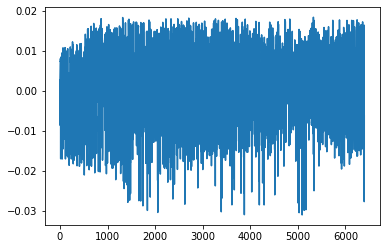

In [15]:
# Draw all z values
points = np.asarray(rotated_plane.points)
plt.plot(points[:,2])
plt.show()

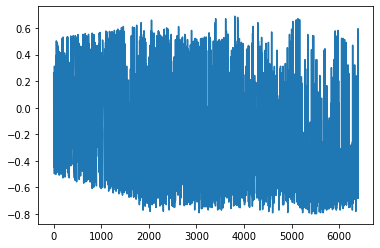

In [16]:
plt.plot(points[:,0])

### Order the points and take the ones furthest away from the plane

In [17]:
# Rotate and translate also the box

rotated_box = copy.deepcopy(box)
rotated_box = rotated_box.rotate(rot_matrix, center=(0,0,0))
translated_box = rotated_box.translate([0, 0, - avg_z])
o3d.visualization.draw_geometries([coord, translated_box, translated_plane])

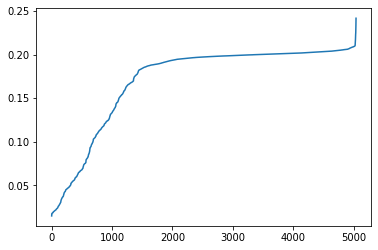

In [18]:
points_np = np.asarray(translated_box.points)
zs = points_np[:, 2]
sorted_zs = np.sort(zs)
plt.plot(sorted_zs)
percentile90 = np.percentile(sorted_zs, 90)
height = percentile90

upper_plane_points_indices = np.nonzero(zs > 0.8 * height)[0]
upper_plane = translated_box.select_by_index(upper_plane_points_indices)
o3d.visualization.draw_geometries([translated_plane, upper_plane]) 

### Bounding box on the 2D points
rect = cv2.minAreaRect(points)
points = cv2.boxPoints(rect)
bottom_points = points, just reducted z by the distance between the planes


---

In [19]:
upper_plane_points = np.asarray(upper_plane.points)
coordinates = np.c_[upper_plane_points[:, 0], upper_plane_points[:, 1]].astype('float32')
rect = cv2.minAreaRect(coordinates)
bounding_box = cv2.boxPoints(rect)

### Visualise the box borders

In [20]:
points_floor = np.c_[bounding_box, np.zeros(4)]
points_top = np.c_[bounding_box, height * np.ones(4)]
box_points = np.concatenate((points_top, points_floor))


rotated_whole_pcl = copy.deepcopy(raw_pcl)
rotated_whole_pcl = rotated_whole_pcl.rotate(rot_matrix, center=(0,0,0))
translated_whole_pcl = rotated_whole_pcl.translate([0, 0, -avg_z])


lines = [
    [0, 4],
    [1, 5],
    [2, 6],
    [3, 7],
    [0,1],
    [1,2],
    [2,3],
    [3,0],
    [4,5],
    [5,6],
    [6,7],
    [7,4],
]

line_set = o3d.geometry.LineSet(
    points = o3d.utility.Vector3dVector(box_points),
    lines = o3d.utility.Vector2iVector(lines),
)

colors = [[1,0,0] for i in range(len(lines))]
line_set.colors = o3d.utility.Vector3dVector(colors)

o3d.visualization.draw_geometries([line_set, translated_whole_pcl])

In [21]:
width, length, height = rect[1][0], rect[1][1], height

In [22]:
width, length, height

(0.4156562387943268, 0.6683571934700012, 0.2035247787882849)